In [0]:
# import libraries that will be needed
import pandas as pd
import numpy as np

# agarrar la tabla del container
pib = spark.read.csv(
    "/mnt/data_lake/SandBox/DataAnalytics/jaime_figueroa/TAM/RawData/DatosPIBMacroRVU", 
    header=True, 
    inferSchema=True,
    lineSep="\n")

# convertir la tabla en pandas
pib = pib.toPandas()

# borrar dos columnas extra. no sé porque se agregan a la tabla al importar
pib.drop('_c28',1,inplace=True)
pib.drop('\r',1,inplace=True)

# convertir columna de fecha a tipo date
pib['Date'] = pd.to_datetime(pib['Date'], format= '%m/%Y')

# crear columnas de año y mes
pib['Year'] = pd.DatetimeIndex(pib['Date']).year
pib['Month'] = pd.DatetimeIndex(pib['Date']).month

In [0]:
# agarrar la tabla masterfinal de databricks
tabla = 'DataSet.masterfinal'
master = spark.sql(f""" select * from {tabla} """)

# convertir tabla masterfinal a pandas
master = master.toPandas()

# agregar columna de mes a la tabla master
master['MONTH'] = pd.DatetimeIndex(master['INVD']).month

# seleccionar las columnas de interés provenientes de la tabla masterfinal
masterdel = master[['YEAR','MONTH','DQUA','DESP','CFCG','CITG']]

In [0]:
# unir las dos tablas por año y mes
union = pd.merge(masterdel,pib,how='inner',left_on=['YEAR','MONTH'],right_on=['Year','Month'])

# quitar las columnas de año y mes ya que había duplicidad
union.drop(['Year','Month'],1,inplace=True)

In [0]:
# filtrar la tabla de unión para conseguir solamente los datos de pedestales monofásicos en méxico privado
unionmxpad = union[union['DESP'] == 'Residenciales']
unionmxpad = unionmxpad[unionmxpad['CFCG'].isin(['FVA', 'PAR', 'FSA', 'FIG', 'CFE'])]
unionmxpad = unionmxpad[unionmxpad['CITG'] == '1PM']
unionmxpad

# valores de la columna son strings. debemos cambiarlos a floats para poder ver la correlación
unionmxpad['Cobre'] = unionmxpad['Cobre'].str.replace(',','')
unionmxpad['Aluminio'] = unionmxpad['Aluminio'].str.replace(',','')

unionmxpad['Cobre'] = unionmxpad['Cobre'].apply(float)
unionmxpad['Aluminio'] = unionmxpad['Aluminio'].apply(float)

# se agrupa por año y mes y se elije el tipo de agregación deseada por columna
df = unionmxpad.groupby(['YEAR','MONTH']).agg({'DQUA':'sum', 'TasaDeCambio':'mean','CPIMex':'mean', 'Intereses':'mean',	'IGAE':'mean','CETES':'mean','GasolinaRegular':'mean','GasolinaPremium':'mean','CPIGas':'mean','Cobre':'mean','Aluminio':'mean','TexOil':'mean','GasNatural':'mean','Acero':'mean','EMBI':'mean','ElectricGenTransDist':'mean','RegistroRUV':'mean','VerificacionRUV':'mean','ProduccionRUV':'mean','PIBMex':'mean','PIBForFish':'mean','PIBConstr':'mean',	'PIBExtract':'mean','PIBManuf':'mean','PIBBev':'mean','PIBUtil':'mean','PIBElec':'mean','PIBServ':'mean'}).reset_index()

# se crean variables nuevos para el pronóstico. estos variables son lags de la columna de DQUA a 3, 6 y 12 meses
df['Lag12'] = df['DQUA'].shift(12)
df['Lag6'] = df['DQUA'].shift(6)
df['Lag3'] = df['DQUA'].shift(3)

# se quitan los NaNs para poner 0s en su lugar porque no se puede correr la función de correlación con NaNs
df.replace(np.NaN, 0, inplace = True)

# creamos una función para agregar una columna de trimestre con label de string
def trimestre(df):
  if df['MONTH'] <= 3:
    return 'T1'
  elif df['MONTH'] >= 4 and df['MONTH'] <= 6:
    return 'T2'
  elif df['MONTH'] >= 7 and df['MONTH'] <= 9:
    return 'T3'
  else:
    return 'T4'

# creamos una función para agregar una columna de trimestre con label numérico
def trimestre2(df):
  if df['MONTH'] <= 3:
    return 1
  elif df['MONTH'] >= 4 and df['MONTH'] <= 6:
    return 2
  elif df['MONTH'] >= 7 and df['MONTH'] <= 9:
    return 3
  else:
    return 4
  
# usamos las funciones para agregar las variables nuevas
df['Trimestre'] = df.apply(trimestre, axis=1)
df['Trimestre2'] = df.apply(trimestre2, axis=1)

In [0]:
# este df es la tabla agrupada por año y mes. nos muestra la cantidad de ventas y el valor del variable en ese año+mes
# pd.set_option('display.max_rows', 138)
df

Out[7]:

,YEAR,MONTH,DQUA,TasaDeCambio,CPIMex,Intereses,IGAE,CETES,GasolinaRegular,GasolinaPremium,CPIGas,Cobre,Aluminio,TexOil,GasNatural,Acero,EMBI,ElectricGenTransDist,RegistroRUV,VerificacionRUV,ProduccionRUV,PIBMex,PIBForFish,PIBConstr,PIBExtract,PIBManuf,PIBBev,PIBUtil,PIBElec,PIBServ,Lag12,Lag6,Lag3,Trimestre,Trimestre2
0,2010,1,73.0,12.8,72.6,5.1,89.8,4.5,0.0,0.0,53.0,7386.0,2235.0,78.2,5.8,553.1,167.8,70.6,0.0,0.0,0.0,83.05,2.73,6.74,4.06,14.62,3.77,1.23,0.92,49.01,0.0,0.0,0.0,T1,1
1,2010,2,73.0,12.9,73.0,5.0,90.1,4.5,0.0,0.0,53.3,6848.0,2049.0,76.4,5.3,589.7,174.9,74.1,0.0,0.0,0.0,83.05,2.73,6.74,4.06,14.62,3.77,1.23,0.92,49.01,0.0,0.0,0.0,T1,1
2,2010,3,92.0,12.6,73.5,5.0,91.3,4.5,0.0,0.0,53.6,7462.0,2205.0,81.2,4.3,635.0,138.1,74.8,0.0,0.0,0.0,83.05,2.73,6.74,4.06,14.62,3.77,1.23,0.92,49.01,0.0,0.0,0.0,T1,1
3,2010,4,41.0,12.2,73.3,5.0,91.4,4.4,0.0,0.0,53.9,7744.0,2316.0,84.5,4.0,674.0,132.4,72.2,0.0,0.0,0.0,83.96,2.89,6.49,4.10,14.94,3.80,1.24,0.94,49.52,0.0,0.0,73.0,T2,2
4,2010,5,98.0,12.8,72.8,5.0,91.5,4.5,0.0,0.0,52.2,6837.0,2040.0,73.8,4.2,690.1,182.8,66.6,0.0,0.0,0.0,83.96,2.89,6.49,4.10,14.94,3.80,1.24,0.94,49.52,0.0,0.0,73.0,T2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,2021,2,396.0,20.3,110.9,4.3,107.1,4.1,19.8,20.4,119.3,8460.3,2079.6,59.1,5.1,1178.3,289.0,108.7,21044.0,16361.0,12966.0,99.81,3.44,6.12,3.08,17.79,4.75,1.48,1.16,62.03,346.0,200.0,311.0,T1,1
134,2021,3,439.0,20.8,111.8,4.2,110.1,4.1,20.1,21.6,125.2,9005.0,2191.6,62.3,2.6,1268.0,290.4,108.9,22126.0,18860.0,15465.0,99.81,3.44,6.12,3.08,17.79,4.75,1.48,1.16,62.03,567.0,261.0,299.0,T1,1
135,2021,4,503.0,20.1,112.2,4.3,109.9,4.1,20.2,21.9,124.5,9335.6,2323.8,61.7,2.6,1377.2,291.6,107.2,16316.0,16387.0,12050.0,100.20,3.46,6.20,3.12,18.00,4.78,1.50,1.18,62.50,252.0,347.0,323.0,T2,2
136,2021,5,471.0,20.0,112.4,4.3,111.0,4.1,20.2,22.0,123.0,10184.0,2433.8,65.2,2.9,1532.1,292.7,103.7,20544.0,16112.0,14214.0,100.20,3.46,6.20,3.12,18.00,4.78,1.50,1.18,62.50,252.0,311.0,396.0,T2,2


In [0]:
# esto lo usamo para ver los histogramas de las variables
# display(df)

In [0]:
# buscamos las correlaciones entre las variables y DQUA para ver qué usar en el modelo
df.corr()['DQUA'].sort_values(ascending=False)

Out[8]: DQUA 1.000000
Lag3 0.527132
Lag12 0.500378
Lag6 0.444314
IGAE 0.377847
ProduccionRUV 0.367661
PIBMex 0.367634
PIBElec 0.341806
PIBManuf 0.341745
PIBServ 0.335071
PIBUtil 0.332560
VerificacionRUV 0.322457
RegistroRUV 0.318002
PIBConstr 0.269887
YEAR 0.235511
PIBBev 0.235432
PIBForFish 0.228580
CPIMex 0.207294
TasaDeCambio 0.205949
CPIGas 0.174336
ElectricGenTransDist 0.170767
MONTH 0.169275
Trimestre2 0.151251
EMBI 0.146102
GasolinaRegular -0.022808
GasolinaPremium -0.023802
PIBExtract -0.059625
Acero -0.065118
CETES -0.105491
Intereses -0.129368
TexOil -0.185540
Cobre -0.247042
Aluminio -0.324566
GasNatural -0.331168
Name: DQUA, dtype: float64

In [0]:
# agarramos métricas de evaluación de modelo
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# aquí se quitan columnas no necesarias para el modelo
X = df.drop(['DQUA', 'YEAR', 'MONTH', 'GasolinaRegular', 'Intereses', 'Acero', 'PIBForFish', 'PIBBev', 'PIBServ', 'Aluminio', 'CPIGas', 'ProduccionRUV', 'Lag3', 'Trimestre'], axis=1)

# se separa el atributo que queremos predecir
y = df['DQUA']

# split a los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# se crea una instancia del modelo
LR = LinearRegression()

# hacemos un fit con la training data
LR.fit(X_train,y_train)

# se hacen predicciones en los datos de prueba
y_prediction =  LR.predict(X_test)

# encontramos las métricas de evaluación de modelo y las imprimimos
R2 = r2_score(y_test,y_prediction)
MAE = mean_absolute_error(y_test, y_prediction)
MSE = mean_squared_error(y_test, y_prediction)

print('R2: ', R2)
print('MAE: ', MAE)
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_prediction)))

R2: 0.6022720645899349
MAE: 60.341937188933535
RMSE: 79.98494751085228

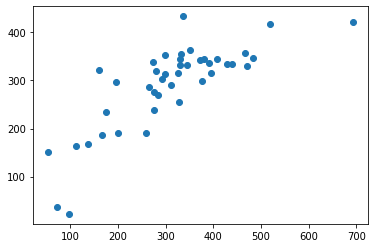

In [0]:
# relación entre las predicciones y el valor real
import matplotlib.pyplot as plt
plt.scatter(y_test, y_prediction);

In [0]:
import shap

# quitando columnas no deseadas
X = df.drop(['DQUA', 'YEAR', 'MONTH', 'Trimestre'], axis = 1)

# columna a predecir
y = df['DQUA']

X100 = shap.utils.sample(X, 100)

model = LinearRegression()
model.fit(X, y)

Out[38]: LinearRegression()

Permutation explainer: 83%|████████▎ | 115/138 [00:00<?, ?it/s]Permutation explainer: 86%|████████▌ | 118/138 [00:10<00:01, 17.24it/s]Permutation explainer: 87%|████████▋ | 120/138 [00:10<00:01, 13.97it/s]Permutation explainer: 88%|████████▊ | 122/138 [00:10<00:01, 12.82it/s]Permutation explainer: 90%|████████▉ | 124/138 [00:10<00:01, 12.26it/s]Permutation explainer: 91%|█████████▏| 126/138 [00:10<00:01, 11.83it/s]Permutation explainer: 93%|█████████▎| 128/138 [00:11<00:00, 11.58it/s]Permutation explainer: 94%|█████████▍| 130/138 [00:11<00:00, 11.57it/s]Permutation explainer: 96%|█████████▌| 132/138 [00:11<00:00, 11.46it/s]Permutation explainer: 97%|█████████▋| 134/138 [00:11<00:00, 11.38it/s]Permutation explainer: 99%|█████████▊| 136/138 [00:11<00:00, 11.26it/s]Permutation explainer: 100%|██████████| 138/138 [00:11<00:00, 11.15it/s]Permutation explainer: 139it [00:12, 1.99it/s]

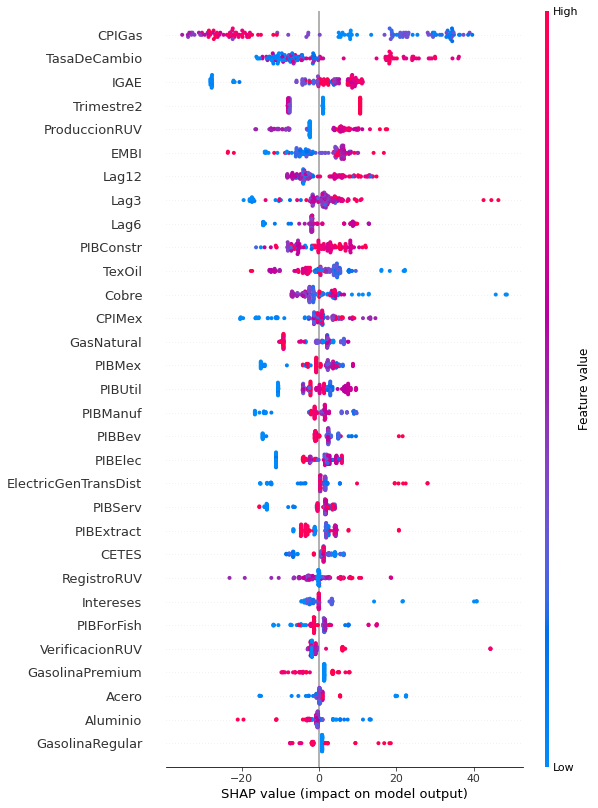

In [0]:
# otra manera de mostrar los valores shap
import interpret.glassbox
model_ebm = interpret.glassbox.ExplainableBoostingRegressor()
model_ebm.fit(X, y)

# explain the GAM model with SHAP
explainer_ebm = shap.Explainer(model_ebm.predict, X100)
shap_values_ebm = explainer_ebm(X)

shap.plots.beeswarm(shap_values_ebm, max_display=32)

In [0]:
# lo requerido para hacer un modelo XGBoost y sus métricas de evaluación
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
from sklearn.model_selection import train_test_split

# quitar columnas que no queremos usar
X = df.drop(['DQUA', 'YEAR', 'MONTH', 'Trimestre', 'GasolinaRegular', 'Intereses', 'Acero', 'PIBForFish', 'PIBBev', 'PIBServ', 'Aluminio', 'CPIGas', 'ProduccionRUV', 'Lag3'], axis=1)

# escoger la columna a predecir
y = df['DQUA']

# hacer el split
seed = 42
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# hacer el fit al modelo
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model.fit(X_train, y_train)

# hacer predicciones
y_prediction = model.predict(X_test)

# encontrar y mostrar las métricas
score=r2_score(y_test,y_prediction)
MAE = mean_absolute_error(y_test, y_prediction)
rmse = np.sqrt(mean_squared_error(y_test, y_prediction))

print('r2 score is: ',score)
print("RMSE: %f" % (rmse))
print('MAE: '+ str(MAE))

r2 score is: 0.3877784157765871
RMSE: 99.236065
MAE: 76.8374073391869

Out[29]:

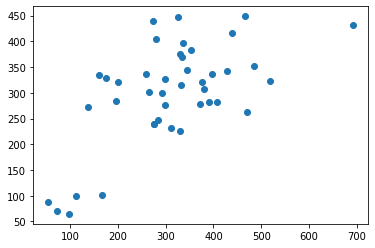

<matplotlib.collections.PathCollection at 0x7fe94fb02610>

In [0]:
# relación entre las predicciones y el valor real
from matplotlib import pyplot as plt
plt.scatter(y_test, y_pred);

In [0]:
# lo requerido para el modelo
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# quitar columnas que no usaremos
X = df.drop(['DQUA', 'YEAR', 'MONTH', 'GasolinaRegular', 'Intereses', 'Acero', 'PIBForFish', 'PIBBev', 'PIBServ', 'Aluminio', 'CPIGas', 'ProduccionRUV', 'Lag3', 'Trimestre'], axis=1)

# escoger columna a predecir
y = df['DQUA']

# crear instancia de variables polinomiales
polynomial_converter = PolynomialFeatures(degree=1, include_bias=False)

# hacer fit a las variables
polynomial_converter.fit(X)

# transformar a las variables polinomiales
polyfeatures = polynomial_converter.transform(X)

# hacer split
X_train, X_test, y_train, y_test = train_test_split(polyfeatures, y, test_size=0.3, random_state=101)

# crear instancia del modelo
model = LinearRegression()

# hacer fit al modelo
model.fit(X_train, y_train)

# hacer predicciones
y_predictions = model.predict(X_test)

# conseguir las métricas
MAE = mean_absolute_error(y_test, y_predictions)
MSE = mean_squared_error(y_test, y_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test, y_predictions)

print('MAE: '+ str(MAE))
print('RMSE: '+ str(RMSE))
print('R2: ' + str(R2))

MAE: 62.736831354023785
RMSE: 84.04291642728947
R2: 0.5066917926755514

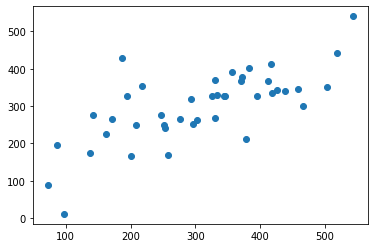

In [0]:
# relación entre las predicciones y el valor real
from matplotlib import pyplot as plt
plt.scatter(y_test, y_predictions);